In [2]:
%matplotlib inline
%run '../bin/notebook_utils.py'
import matplotlib.ticker as mticker

In [124]:
# Frontera, default MPI
sscaling1_sessions = pd.read_csv('../data/spatial-heterogeneity/sessions.csv', index_col=0)
sscaling1_pilots = pd.read_csv('../data/spatial-heterogeneity/pilots.csv', index_col=0)
sscaling1_units = pd.read_csv('../data/spatial-heterogeneity/units.csv', index_col=0)

In [125]:
print('Strong scaling 1: Total number of successful runs: %s' % sscaling1_sessions.shape[0])
print('Strong scaling 1: Total number of pilots: %s' % sscaling1_pilots.shape[0])
print('Strong scaling 1: Total number of units: %s' % sscaling1_units.shape[0])

Strong scaling 1: Total number of successful runs: 20
Strong scaling 1: Total number of pilots: 20
Strong scaling 1: Total number of units: 163840


In [136]:
sscaling1_sessions['nnode'] = sscaling1_sessions.ncore/56
sscaling1_sessions['list'] = sscaling1_sessions[['nnode', 'nunit']].astype(int, errors='ignore').astype('str').values.tolist()
sscaling1_sessions['nnodeunit'] = sscaling1_sessions['list'].apply('/'.join)
sscaling1_sessions['Agent overhead'] = sscaling1_sessions['util_p_total'] - sscaling1_sessions['cu_exec_start_stop']

sscaling1_ws = sscaling1_sessions[['nnode', 'nnodeunit', 'TTC', 'P_LRMS_QUEUING', 'U_AGENT_QUEUING',
                                   'U_AGENT_SCHEDULING', 'U_AGENT_QUEUING_EXEC', 'U_AGENT_EXECUTING',
                                   'cu_exec_start_stop', 'nunit_failed', 'util_p_total', 'Agent overhead']
                        ].groupby(['nnode', 'nnodeunit']).aggregate(
    {'TTC'                 : ['mean', 'std'],
     'P_LRMS_QUEUING'      : ['mean', 'std'],
     'U_AGENT_QUEUING'     : ['mean', 'std'],
     'U_AGENT_SCHEDULING'  : ['mean', 'std'],
     'U_AGENT_QUEUING_EXEC': ['mean', 'std'],
     'U_AGENT_EXECUTING'   : ['mean', 'std'],
     'cu_exec_start_stop'  : ['mean', 'std'],
     'util_p_total'        : ['mean', 'std'],
     'Agent overhead'      : ['mean', 'std'],
     'nunit_failed'        : ['mean']
     })

sscaling1_ws.rename({'P_LRMS_QUEUING'      : 'TTQ'},                      axis='columns', inplace=True)
sscaling1_ws.rename({'U_AGENT_QUEUING'     : 'Agent queueing'},           axis='columns', inplace=True)
sscaling1_ws.rename({'U_AGENT_SCHEDULING'  : 'Agent scheduling'},         axis='columns', inplace=True)
sscaling1_ws.rename({'U_AGENT_QUEUING_EXEC': 'Agent queueing execution'}, axis='columns', inplace=True)
sscaling1_ws.rename({'U_AGENT_EXECUTING'   : 'TTX Executor'},             axis='columns', inplace=True)
sscaling1_ws.rename({'cu_exec_start_stop'  : 'TTX Unit'},                 axis='columns', inplace=True)
sscaling1_ws.rename({'util_p_total'        : 'TTX'},                      axis='columns', inplace=True)

sscaling1_ws = sscaling1_ws.sort_values('nnode')
sscaling1_ws

TTC                         TTQ               Agent queueing           Agent scheduling             Agent queueing execution            TTX Executor                 TTX Unit                      TTX             Agent overhead            nunit_failed
                         mean            std         mean           std           mean       std             mean         std                     mean        std         mean         std         mean         std         mean         std           mean        std         mean
nnode nnodeunit                                                                                                                                                                                                                                                                    
8.0   8/8192     1.583476e+09   36571.810345    69.484816     46.082867      83.780278  0.354989      3554.841541  124.827765               110.699771  40.890245  3564.349803  125.294209  3546.345314  134.504699  3647.350575  164.249977     101.005261  47.905985            0
16.0  16/8192    1.583461e+09    2960.918820    51.901429      4.115843      83.716334  0.316779      1821.118716   20.205983               115.399189   9.832127  1831.818271   19.540710  1831.538284   19.491383  1897.057333   23.435546      65.519049   4.141676            0
32.0  32/8192    1.583331e+09  316595.121423    51.432908      7.297505      84.021046  0.187984       890.762330   21.753731               121.232652   8.684733   901.000482   21.134082   900.722745   21.151032   964.499000   25.501951      63.776255   6.079899            0
64.0  64/8192    1.583360e+09  334050.981721  1178.763154    935.826359      84.389523  0.311671       449.345162   19.795660               146.564457  14.099684   460.713358   20.688457   460.424266   20.624213   530.259450   28.638109      69.835184  13.723992            0
128.0 128/8192   1.583470e+09   97940.732051  9777.677677  14118.127015      84.372826  0.312578       259.069197    7.921012               156.806711   4.843423   269.515597    7.813312   269.271437    7.801281   330.104900   11.411552      60.833463   5.326999            0

In [137]:
# Total agent time = 
#    ru.STATE: rp.AGENT_SCHEDULING             - ru.STATE: rp.AGENT_SCHEDULING_PENDING +
#    ru.STATE: rp.AGENT_EXECUTING_PENDING      - ru.STATE: rp.AGENT_SCHEDULING         +
#    ru.STATE: rp.AGENT_EXECUTING              - ru.STATE: rp.AGENT_EXECUTING_PENDING  +
#    ru.STATE: rp.AGENT_STAGING_OUTPUT_PENDING - ru.STATE: rp.AGENT_EXECUTING          -
#    ru.EVENT: 'cu_exec_stop'                  - ru.EVENT: 'cu_exec_start'

oh1 = sscaling1_ws.copy(deep=True)
oh1.loc[:,('TTX Agent','mean')] = (oh1.loc[:,('Agent queueing','mean')]            + \
                                   oh1.loc[:,('Agent scheduling','mean')]          + \
                                   oh1.loc[:,('Agent queueing execution','mean')]) + \
                                  (oh1.loc[:,('TTX Executor','mean')]                 - \
                                   oh1.loc[:,('TTX Unit','mean')])
# oh1.loc[:,('TTX Unit','mean')]  = oh1.loc[:,('TTX Unit','mean')] - 900
oh1.loc[:,('nunit_failed','mean')] = oh1.loc[:,('nunit_failed','mean')].apply(np.ceil)

oh1.columns = [' '.join(col).strip() for col in oh1.columns.values]

oh1 = oh1.sort_values('nnode')
oh1 = oh1.reset_index()
oh1

,nnode,nnodeunit,TTC mean,TTC std,TTQ mean,TTQ std,Agent queueing mean,Agent queueing std,Agent scheduling mean,Agent scheduling std,...,TTX Executor mean,TTX Executor std,TTX Unit mean,TTX Unit std,TTX mean,TTX std,Agent overhead mean,Agent overhead std,nunit_failed mean,TTX Agent mean
0,8.0,8/8192,1.583476e+09,36571.810345,69.484816,46.082867,83.780278,0.354989,3554.841541,124.827765,...,3564.349803,125.294209,3546.345314,134.504699,3647.350575,164.249977,101.005261,47.905985,0.0,3767.326079
1,16.0,16/8192,1.583461e+09,2960.918820,51.901429,4.115843,83.716334,0.316779,1821.118716,20.205983,...,1831.818271,19.540710,1831.538284,19.491383,1897.057333,23.435546,65.519049,4.141676,0.0,2020.514227
2,32.0,32/8192,1.583331e+09,316595.121423,51.432908,7.297505,84.021046,0.187984,890.762330,21.753731,...,901.000482,21.134082,900.722745,21.151032,964.499000,25.501951,63.776255,6.079899,0.0,1096.293765
3,64.0,64/8192,1.583360e+09,334050.981721,1178.763154,935.826359,84.389523,0.311671,449.345162,19.795660,...,460.713358,20.688457,460.424266,20.624213,530.259450,28.638109,69.835184,13.723992,0.0,680.588234
4,128.0,128/8192,1.583470e+09,97940.732051,9777.677677,14118.127015,84.372826,0.312578,259.069197,7.921012,...,269.515597,7.813312,269.271437,7.801281,330.104900,11.411552,60.833463,5.326999,0.0,500.492894


In [145]:
# Total agent time = 'util_p_total'
# ru.EVENT: 'bootstrap_0_stop' - ru.EVENT: 'bootstrap_0_start'

ttc1 = sscaling1_ws[['TTX', 'TTX Unit', 'Agent overhead']].copy()
ttc1.columns = [' '.join(col).strip() for col in ttc1.columns.values]
ttc1 = ttc1.sort_values('nnode')
ttc1 = ttc1.reset_index()

ttc1


,nnode,nnodeunit,TTX mean,TTX std,TTX Unit mean,TTX Unit std,Agent overhead mean,Agent overhead std
0,8.0,8/8192,3647.350575,164.249977,3546.345314,134.504699,101.005261,47.905985
1,16.0,16/8192,1897.057333,23.435546,1831.538284,19.491383,65.519049,4.141676
2,32.0,32/8192,964.499000,25.501951,900.722745,21.151032,63.776255,6.079899
3,64.0,64/8192,530.259450,28.638109,460.424266,20.624213,69.835184,13.723992
4,128.0,128/8192,330.104900,11.411552,269.271437,7.801281,60.833463,5.326999


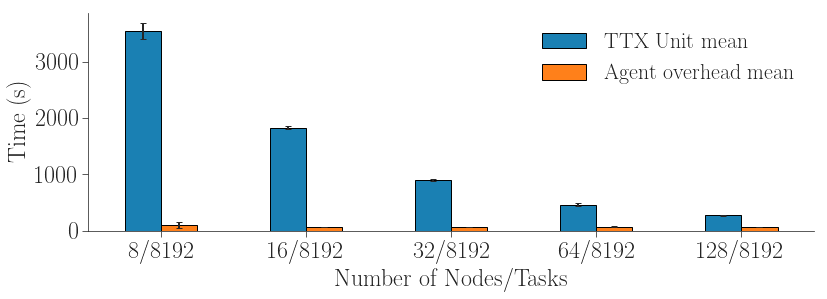

In [165]:
fig, ax = fig_setup(figsize=(13,4))

means = ttc1[['nnodeunit','TTX Unit mean', 'Agent overhead mean']]
errors = ttc1[['TTX Unit std', 'Agent overhead std']]

means.plot.bar(
    x='nnodeunit',
    yerr=errors.T.values, 
    width=0.5, 
    color=[tableau20[0], tableau20[2]], 
    ax=ax, 
    rot=0,
    legend=True)

ax.set_xlabel('Number of Nodes/Tasks')
ax.set_ylabel('Time (s)')

plt.savefig('figures/strong_scaling_ttc.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/strong_scaling_ttc.png', dpi=300, bbox_inches='tight')

In [166]:
# sessions sscaling1
# sscaling1_sids = sorted(['../data/spatial-heterogeneity/sscaling1/'+s for s in sscaling1_sessions.drop_duplicates(['nunit']).index.unique().tolist()])
# sscaling1_sobjs = ra.Experiment(sscaling1_sids, stype='radical.pilot')
sscaling1_sobjs = ra.Experiment(['../data/spatial-heterogeneity/sscaling1/rp.session.login3.frontera.tacc.utexas.edu.mturilli.018326.0004',
                                 '../data/spatial-heterogeneity/sscaling1/rp.session.login3.frontera.tacc.utexas.edu.mturilli.018327.0002',
                                 '../data/spatial-heterogeneity/sscaling1/rp.session.login3.frontera.tacc.utexas.edu.mturilli.018327.0008',
                                 '../data/spatial-heterogeneity/sscaling1/rp.session.login3.frontera.tacc.utexas.edu.mturilli.018327.0013',
                                 '../data/spatial-heterogeneity/sscaling1/rp.session.login3.frontera.tacc.utexas.edu.mturilli.018327.0016'], stype='radical.pilot')

cache read failed: [Errno 2] No such file or directory: '/Users/mturilli/.radical/analytics/cache//rp.session.login3.frontera.tacc.utexas.edu.mturilli.018326.0004.pickle'
session loaded
cache read failed: [Errno 2] No such file or directory: '/Users/mturilli/.radical/analytics/cache//rp.session.login3.frontera.tacc.utexas.edu.mturilli.018327.0002.pickle'
session loaded
cache read failed: [Errno 2] No such file or directory: '/Users/mturilli/.radical/analytics/cache//rp.session.login3.frontera.tacc.utexas.edu.mturilli.018327.0008.pickle'
session loaded
cache read failed: [Errno 2] No such file or directory: '/Users/mturilli/.radical/analytics/cache//rp.session.login3.frontera.tacc.utexas.edu.mturilli.018327.0013.pickle'
session loaded
cache read failed: [Errno 2] No such file or directory: '/Users/mturilli/.radical/analytics/cache//rp.session.login3.frontera.tacc.utexas.edu.mturilli.018327.0016.pickle'
session loaded


In [167]:
metrics_default = [

        # pilot overheads (global)
        ['Pilot Startup',     ['boot', 'setup_1']],
        ['Pilot Termination', ['term' ]],

        # derived pilot durations
        ['Agent Nodes',       ['agent']],
        ['Warmup',            ['warm' ]],
        ['Draining',          ['drain']],
        ['Idle',              ['idle' ]],

        # unit durations (PRTE)
        ['Prepare Execution', ['exec_queue', 'exec_prep']],
        ['Execution RP',      ['exec_rp', 'exec_sh', 'term_sh', 'term_rp']],
        ['Execution Cmd',     ['exec_cmd']],
        ['Unschedule',        ['unschedule']],
]

In [168]:
# choose the metrics we want to use for resource utilization
metrics = metrics_default

# get utilization information
provided_sscaling1, consumed_sscaling1, stats_abs_sscaling1, stats_rel_sscaling1, info_sscaling1 = sscaling1_sobjs.utilization(metrics=metrics)


In [169]:
# x-axis labels
xkeys_sscaling1 = list()

# get the numbers we actually want to plot
for session in sscaling1_sobjs.sessions:

    n_units = len(session.get(etype='unit'))
    
    p_size = 0
    for pilot in session.get(etype='pilot'):
        p_size += pilot.description['cores']

    xkeys_sscaling1.append('%s / %s' % (n_units, p_size))

In [170]:
def update_ticks(x, pos):
    return int(x/4)

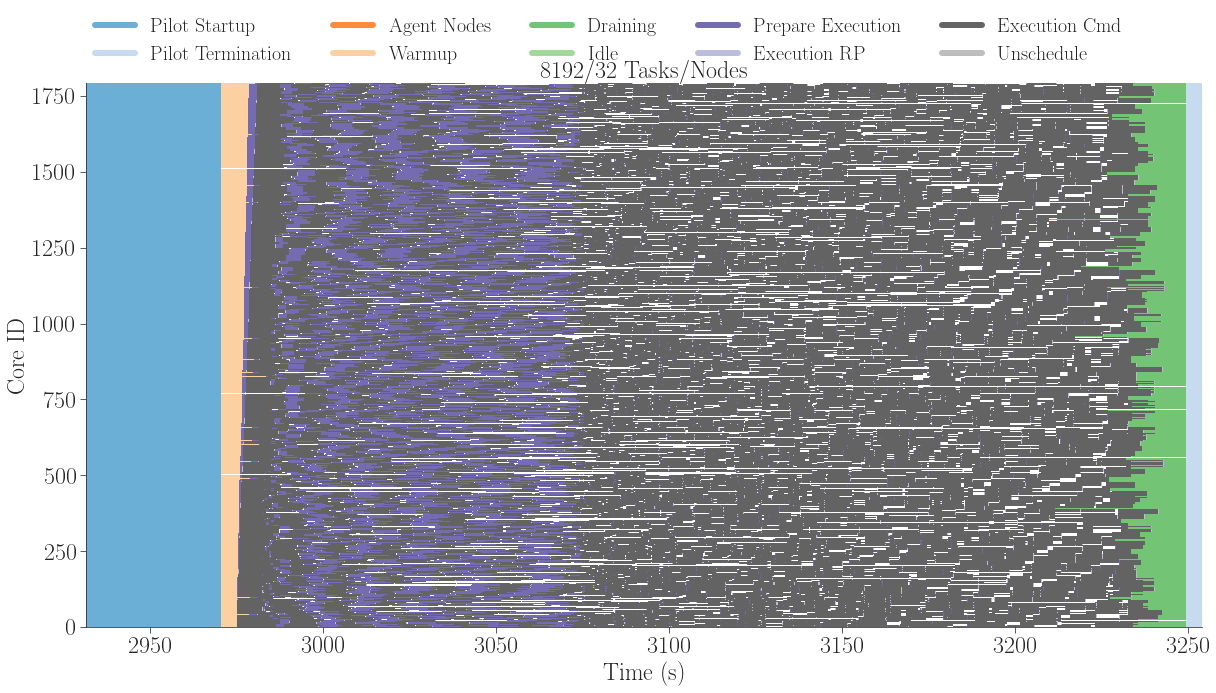

In [171]:
# core utilization over time (box plot)
sid = 'rp.session.login3.frontera.tacc.utexas.edu.mturilli.018327.0016' # 8192 units| 2 nodes
consumed = consumed_sscaling1

fig, ax = fig_setup(figsize=(20,10))

cmap = mpl.cm.get_cmap('tab20c')

step = 1.0 / (len(metrics) + 1)
this = step / 1.0
legend = list()

x_min = None
x_max = None
y_min = None
y_max = None

ax.title.set_text('%s/%s Tasks/Nodes' % ('8192','32'))#(sscaling_sessions.loc[sid].nunit, int(sscaling_sessions.loc[sid].nnode)))

for metric in metrics:

    color = cmap(this)
    this += step

    legend.append(mpl.lines.Line2D([0], [0], color=color, lw=6))

    if isinstance(metric, list):
        name = metric[0]
        parts = metric[1]
    else:
        name = metric
        parts = [metric]

    for part in parts:
        for uid in consumed[sid][part]:
            for block in consumed[sid][part][uid]:
                orig_x = block[0]
                orig_y = block[2] - 0.5
                width = block[1] - block[0]
                height = block[3] - block[2] + 1.0

                if x_min is None:
                    x_min = orig_x
                if x_max is None:
                    x_max = orig_x + width
                if y_min is None:
                    y_min = orig_x
                if y_max is None:
                    y_max = orig_x + height

                x_min = min(x_min, orig_x)
                y_min = min(y_min, orig_y)
                x_max = max(x_max, orig_x + width)
                y_max = max(y_max, orig_y + height)

                patch = mpl.patches.Rectangle((orig_x, orig_y),
                                              width, height,
                                              facecolor=color,
                                              edgecolor='black',
                                              fill=True, lw=0.0)
                ax.add_patch(patch)

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

ax.set_xlabel('Time (s)')
ax.set_ylabel('Core ID')

ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

# Add legend
lgd = fig.legend(legend, 
       [m[0] for m in metrics], 
       loc='upper center', 
       # bbox_to_anchor=(0.5, 1.03),
       fontsize=20,
       ncol=5)

plt.savefig('figures/paper_rp_frontera_strong_scaling_heterogeneous.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/paper_rp_frontera_strong_scaling_heterogeneous.png', dpi=300, bbox_inches='tight')

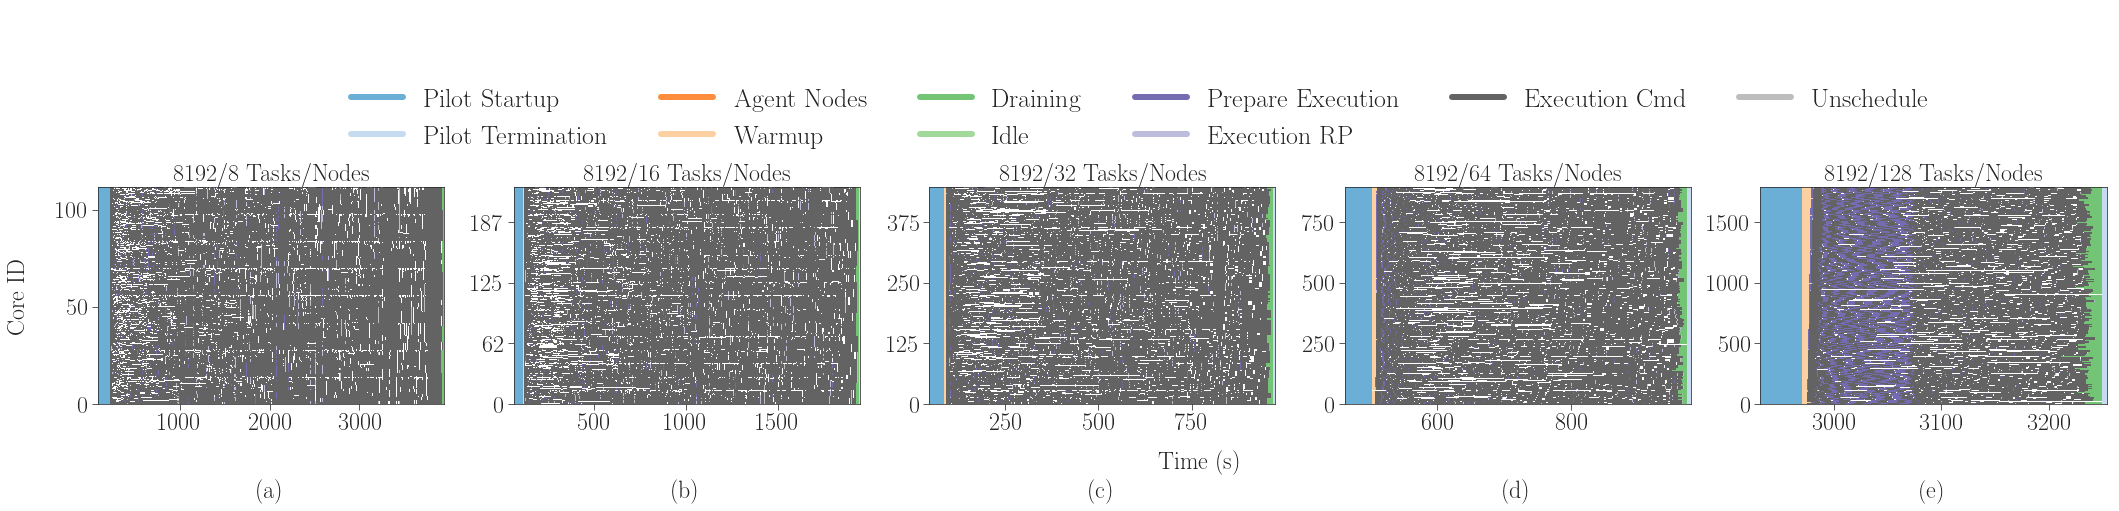

In [172]:
# xkeys = xkeys_exp4
provided = provided_sscaling1
consumed = consumed_sscaling1
stats_rel = stats_abs_sscaling1

sids = [ 'rp.session.login3.frontera.tacc.utexas.edu.mturilli.018326.0004', # 448
         'rp.session.login3.frontera.tacc.utexas.edu.mturilli.018327.0002', # 896
         'rp.session.login3.frontera.tacc.utexas.edu.mturilli.018327.0008', # 1792
         'rp.session.login3.frontera.tacc.utexas.edu.mturilli.018327.0013', # 3584
         'rp.session.login3.frontera.tacc.utexas.edu.mturilli.018327.0016'] # 7168

fwidth = 36
fhight = 4
fig, axarr = plt.subplots(1,
                          len(sids),
                          sharex='col',
                          figsize=(fwidth, fhight))  # , sharey='row')

i = 0
j = 'a'
for sid in sids:

    ax = axarr[i]
    cmap = mpl.cm.get_cmap('tab20c')

    step = 1.0 / (len(metrics) + 1)
    this = step / 1.0
    legend = list()

    x_min = None
    x_max = None
    y_min = None
    y_max = None
    
    ax.title.set_text('%s/%s Tasks/Nodes' % (sscaling1_sessions.loc[sid].nunit, int(sscaling1_sessions.loc[sid].nnode)))

    for metric in metrics:

        color = cmap(this)
        this += step

        legend.append(mpl.lines.Line2D([0], [0], color=color, lw=6))

        if isinstance(metric, list):
            name = metric[0]
            parts = metric[1]
        else:
            name = metric
            parts = [metric]

        for part in parts:
            for uid in consumed[sid][part]:
                for block in consumed[sid][part][uid]:
                    orig_x = block[0]
                    orig_y = block[2] - 0.5
                    width = block[1] - block[0]
                    height = block[3] - block[2] + 1.0

                    if x_min is None:
                        x_min = orig_x
                    if x_max is None:
                        x_max = orig_x + width
                    if y_min is None:
                        y_min = orig_x
                    if y_max is None:
                        y_max = orig_x + height

                    x_min = min(x_min, orig_x)
                    y_min = min(y_min, orig_y)
                    x_max = max(x_max, orig_x + width)
                    y_max = max(y_max, orig_y + height)

                    patch = mpl.patches.Rectangle((orig_x, orig_y),
                                                  width, height,
                                                  facecolor=color,
                                                  edgecolor='black',
                                                  fill=True, lw=0.0)
                    ax.add_patch(patch)

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    
    ax.set_xlabel('(%s)' % j, labelpad=45)
    
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    i = i+1
    j = chr(ord(j) + 1)

# Add common axes lables
fig.text(0.09, 0.5, 'Core ID', va='center', rotation='vertical', fontsize=24)
fig.text(0.55, -0.1, 'Time (s)', ha='center', fontsize=24)
    
# Add legend
fig.legend(legend, 
           [m[0] for m in metrics], 
           loc='upper center', 
           bbox_to_anchor=(0.44, 1.55),
           fontsize=26,
           ncol=6)

plt.savefig('figures/strung_scaling_ru_multi.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/strung_scaling_ru_multi.png', dpi=300, bbox_inches='tight')